In [1]:
# Importing Libraries

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
np.random.seed(42)

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.compat.v1.get_default_graph

<function tensorflow.python.framework.ops.get_default_graph()>

In [9]:
# # Configuring a session
# session_conf = tf.ConfigProto(
#     intra_op_parallelism_threads=1,
#     inter_op_parallelism_threads=1
# )

In [10]:
# Import Keras
from tensorflow.keras import backend as K

In [11]:
# Importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, BatchNormalization, Flatten, Conv1D, MaxPool1D
from tensorflow.keras.layers import Dense, Dropout

In [12]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [13]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

c:\users\sahil\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
c:\users\sahil\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [14]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [15]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((7352, 128, 9), (2947, 128, 9), (7352, 6), (2947, 6))

In [0]:
Act_Ytr = np.argmax(Y_train, axis=1)
Act_Yts = np.argmax(Y_test, axis=1)

In [0]:
# Separate static and dynamic
# static label as 1: dynamic label as 0
static_Xtr = []
static_ytr = []
for i in range(Act_Ytr.shape[0]):
    static_Xtr.append(X_train[i])
    if Act_Ytr[i] == 0 or Act_Ytr[i] == 1 or Act_Ytr[i] == 2:
        static_ytr.append(0)
    else:
        static_ytr.append(1)
        
static_Xts = []
static_yts = []
for i in range(Act_Yts.shape[0]):
    static_Xts.append(X_test[i])
    if Act_Yts[i] == 0 or Act_Yts[i] == 1 or Act_Yts[i] == 2:
        static_yts.append(0)
    else:
        static_yts.append(1)

In [0]:
static_Xtr = np.array(static_Xtr)
static_ytr = np.array(static_ytr)
static_Xts = np.array(static_Xts)
static_yts = np.array(static_yts)

In [0]:
static_Xtr.shape, static_Xts.shape, static_ytr.shape, static_yts.shape

((7352, 128, 9), (2947, 128, 9), (7352,), (2947,))

# Stage 1

In [0]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
epochs = 30
batch_size = 32

In [16]:
def create_model_stage_1(k1,d1,optimizer='adam'):
    model = Sequential()
    model.add(LSTM(k1, input_shape=(timesteps,input_dim), kernel_initializer=tf.keras.initializers.glorot_normal(seed=42)))
    model.add(Dropout(d1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [0]:
%%time
# Ref: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

# create model
model = KerasClassifier(build_fn=create_model_stage_1, epochs=epochs, batch_size=batch_size, verbose=0)
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
k1 = [8,16,32]
d1 = [0.4,0.5,0.6]
param_grid = dict(k1=k1, d1=d1,optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10)
grid_result = grid.fit(static_Xtr, static_ytr)

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] d1=0.4, k1=8, optimizer=SGD .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......... d1=0.4, k1=8, optimizer=SGD, score=0.963, total=  30.4s
[CV] d1=0.4, k1=8, optimizer=SGD .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s remaining:    0.0s


[CV] ......... d1=0.4, k1=8, optimizer=SGD, score=0.990, total=  27.5s
[CV] d1=0.4, k1=8, optimizer=SGD .....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.7s remaining:    0.0s


[CV] ......... d1=0.4, k1=8, optimizer=SGD, score=0.959, total=  27.9s
[CV] d1=0.4, k1=8, optimizer=RMSprop .................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.4min remaining:    0.0s


[CV] ..... d1=0.4, k1=8, optimizer=RMSprop, score=0.989, total=  27.6s
[CV] d1=0.4, k1=8, optimizer=RMSprop .................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.9min remaining:    0.0s


[CV] ..... d1=0.4, k1=8, optimizer=RMSprop, score=0.987, total=  27.6s
[CV] d1=0.4, k1=8, optimizer=RMSprop .................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min remaining:    0.0s


[CV] ..... d1=0.4, k1=8, optimizer=RMSprop, score=0.980, total=  27.3s
[CV] d1=0.4, k1=8, optimizer=Adagrad .................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  2.8min remaining:    0.0s


[CV] ..... d1=0.4, k1=8, optimizer=Adagrad, score=0.785, total=  27.1s
[CV] d1=0.4, k1=8, optimizer=Adagrad .................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  3.3min remaining:    0.0s


[CV] ..... d1=0.4, k1=8, optimizer=Adagrad, score=0.887, total=  27.1s
[CV] d1=0.4, k1=8, optimizer=Adagrad .................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  3.7min remaining:    0.0s


[CV] ..... d1=0.4, k1=8, optimizer=Adagrad, score=0.792, total=  26.9s
[CV] d1=0.4, k1=8, optimizer=Adadelta ................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  4.2min remaining:    0.0s


[CV] .... d1=0.4, k1=8, optimizer=Adadelta, score=0.526, total=  27.1s
[CV] d1=0.4, k1=8, optimizer=Adadelta ................................
[CV] .... d1=0.4, k1=8, optimizer=Adadelta, score=0.602, total=  27.2s
[CV] d1=0.4, k1=8, optimizer=Adadelta ................................
[CV] .... d1=0.4, k1=8, optimizer=Adadelta, score=0.599, total=  27.2s
[CV] d1=0.4, k1=8, optimizer=Adam ....................................
[CV] ........ d1=0.4, k1=8, optimizer=Adam, score=0.999, total=  27.2s
[CV] d1=0.4, k1=8, optimizer=Adam ....................................
[CV] ........ d1=0.4, k1=8, optimizer=Adam, score=0.998, total=  27.5s
[CV] d1=0.4, k1=8, optimizer=Adam ....................................
[CV] ........ d1=0.4, k1=8, optimizer=Adam, score=0.954, total=  27.3s
[CV] d1=0.4, k1=8, optimizer=Adamax ..................................
[CV] ...... d1=0.4, k1=8, optimizer=Adamax, score=0.998, total=  27.4s
[CV] d1=0.4, k1=8, optimizer=Adamax ..................................
[CV] .

[CV] ..... d1=0.5, k1=8, optimizer=RMSprop, score=0.996, total=  29.3s
[CV] d1=0.5, k1=8, optimizer=RMSprop .................................
[CV] ..... d1=0.5, k1=8, optimizer=RMSprop, score=0.971, total=  27.7s
[CV] d1=0.5, k1=8, optimizer=Adagrad .................................
[CV] ..... d1=0.5, k1=8, optimizer=Adagrad, score=0.738, total=  27.2s
[CV] d1=0.5, k1=8, optimizer=Adagrad .................................
[CV] ..... d1=0.5, k1=8, optimizer=Adagrad, score=0.751, total=  27.8s
[CV] d1=0.5, k1=8, optimizer=Adagrad .................................
[CV] ..... d1=0.5, k1=8, optimizer=Adagrad, score=0.787, total=  27.8s
[CV] d1=0.5, k1=8, optimizer=Adadelta ................................
[CV] .... d1=0.5, k1=8, optimizer=Adadelta, score=0.647, total=  27.8s
[CV] d1=0.5, k1=8, optimizer=Adadelta ................................
[CV] .... d1=0.5, k1=8, optimizer=Adadelta, score=0.624, total=  27.9s
[CV] d1=0.5, k1=8, optimizer=Adadelta ................................
[CV] .

W0320 23:02:06.027496  4600 nn_ops.py:4372] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV] ...... d1=0.5, k1=32, optimizer=Nadam, score=0.984, total=  29.3s
[CV] d1=0.6, k1=8, optimizer=SGD .....................................


W0320 23:02:06.216981  4600 nn_ops.py:4372] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0320 23:02:06.520184  4600 nn_ops.py:4372] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0320 23:02:32.969807  4600 nn_ops.py:4372] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV] ......... d1=0.6, k1=8, optimizer=SGD, score=0.694, total=  26.9s
[CV] d1=0.6, k1=8, optimizer=SGD .....................................


W0320 23:02:33.161296  4600 nn_ops.py:4372] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


[CV] ......... d1=0.6, k1=8, optimizer=SGD, score=0.824, total=  27.9s
[CV] d1=0.6, k1=8, optimizer=SGD .....................................
[CV] ......... d1=0.6, k1=8, optimizer=SGD, score=0.806, total=  28.0s
[CV] d1=0.6, k1=8, optimizer=RMSprop .................................
[CV] ..... d1=0.6, k1=8, optimizer=RMSprop, score=0.995, total=  29.4s
[CV] d1=0.6, k1=8, optimizer=RMSprop .................................
[CV] ..... d1=0.6, k1=8, optimizer=RMSprop, score=0.991, total=  29.2s
[CV] d1=0.6, k1=8, optimizer=RMSprop .................................
[CV] ..... d1=0.6, k1=8, optimizer=RMSprop, score=0.964, total=  28.9s
[CV] d1=0.6, k1=8, optimizer=Adagrad .................................
[CV] ..... d1=0.6, k1=8, optimizer=Adagrad, score=0.872, total=  28.7s
[CV] d1=0.6, k1=8, optimizer=Adagrad .................................
[CV] ..... d1=0.6, k1=8, optimizer=Adagrad, score=0.795, total=  28.3s
[CV] d1=0.6, k1=8, optimizer=Adagrad .................................
[CV] .

[CV] ..... d1=0.6, k1=32, optimizer=Adamax, score=0.980, total=  28.3s
[CV] d1=0.6, k1=32, optimizer=Nadam ..................................
[CV] ...... d1=0.6, k1=32, optimizer=Nadam, score=0.984, total=  29.8s
[CV] d1=0.6, k1=32, optimizer=Nadam ..................................
[CV] ...... d1=0.6, k1=32, optimizer=Nadam, score=0.993, total=  29.2s
[CV] d1=0.6, k1=32, optimizer=Nadam ..................................
[CV] ...... d1=0.6, k1=32, optimizer=Nadam, score=0.983, total=  29.3s


[Parallel(n_jobs=1)]: Done 189 out of 189 | elapsed: 89.2min finished


Wall time: 1h 29min 51s


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.996463 using {'d1': 0.5, 'k1': 16, 'optimizer': 'RMSprop'}
0.970619 (0.013647) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'SGD'}
0.985581 (0.003792) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'RMSprop'}
0.821677 (0.046552) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'Adagrad'}
0.575629 (0.035174) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'Adadelta'}
0.983538 (0.020976) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'Adam'}
0.985581 (0.008524) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'Adamax'}
0.985310 (0.009604) with: {'d1': 0.4, 'k1': 8, 'optimizer': 'Nadam'}
0.992246 (0.004359) with: {'d1': 0.4, 'k1': 16, 'optimizer': 'SGD'}
0.991022 (0.005567) with: {'d1': 0.4, 'k1': 16, 'optimizer': 'RMSprop'}
0.937420 (0.063481) with: {'d1': 0.4, 'k1': 16, 'optimizer': 'Adagrad'}
0.554556 (0.079254) with: {'d1': 0.4, 'k1': 16, 'optimizer': 'Adadelta'}
0.983404 (0.011094) with: {'d1': 0.4, 'k1': 16, 'optimizer': 'Adam'}
0.987893 (0.009581) with: {'d1': 0.4, 'k1': 16, 'optimizer': 'Adamax'}
0.987758 (0.003787) 

In [0]:
%load_ext tensorboard
logdir = log_dir="logs\\stage_1\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
model_1 = create_model_stage_1(k1=16,d1=0.5,optimizer='RMSprop')
history = model_1.fit(static_Xtr, static_ytr, epochs=epochs, batch_size=batch_size, validation_data=(static_Xts,static_yts), callbacks=[tensorboard_callback], verbose=0)

W0320 23:34:06.573614  4600 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (0.159144). Check your callbacks.


In [0]:
model_1.evaluate(static_Xts,static_yts)

2947/2947 [==============================] - 0s 114us/sample - loss: 0.0352 - accuracy: 0.9973


[0.03517710592085603, 0.99728537]

In [0]:
model_1.save_weights('model_stage_1.h5')

In [0]:
%tensorboard --logdir logs\\stage_1  --host localhost

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 2528.

<img src='stage_1.PNG' />

In [0]:
y_prob = np.array(model_1.predict(static_Xts).tolist()).ravel()
y_prob[:5]

array([0.99999976, 0.99999976, 0.99999976, 0.99999976, 0.99999976])

In [0]:
y_pred = []
for i in y_prob:
    if i > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
y_pred = np.array(y_pred)
y_pred.shape

(2947,)

In [0]:
# ==== df_static =====
df_X_tr = []
df_y_tr = []
df_X_ts = []
df_y_ts = []

for i in range(static_ytr.shape[0]):
    if static_ytr[i] == 1:
        df_X_tr.append(X_train[i])
        df_y_tr.append(Y_train[i])
        
for i in range(static_yts.shape[0]):
    if y_pred[i] == 1:
        df_X_ts.append(X_test[i])
        df_y_ts.append(Y_test[i])

In [0]:
df_X_tr = np.array(df_X_tr)
df_X_ts = np.array(df_X_ts)
df_y_tr = np.array(df_y_tr)
df_y_ts = np.array(df_y_ts)

In [0]:
# Saving static df only
np.save('st_X_tr',df_X_tr)
np.save('st_X_ts',df_X_ts)
np.save('st_y_tr',df_y_tr)
np.save('st_y_ts',df_y_ts)

In [0]:
# ==== df_dynmic =====
df_X_tr = []
df_y_tr = []
df_X_ts = []
df_y_ts = []

for i in range(static_ytr.shape[0]):
    if static_ytr[i] == 0:
        df_X_tr.append(X_train[i])
        df_y_tr.append(Y_train[i])
        
for i in range(static_yts.shape[0]):
    if y_pred[i] == 0:
        df_X_ts.append(X_test[i])
        df_y_ts.append(Y_test[i])

In [0]:
df_X_tr = np.array(df_X_tr)
df_X_ts = np.array(df_X_ts)
df_y_tr = np.array(df_y_tr)
df_y_ts = np.array(df_y_ts)

In [0]:
# Saving static df only
np.save('dy_X_tr',df_X_tr)
np.save('dy_X_ts',df_X_ts)
np.save('dy_y_tr',df_y_tr)
np.save('dy_y_ts',df_y_ts)

# Stage 2

**Static**

In [0]:
df_X_tr = np.load('st_X_tr.npy')
df_X_ts = np.load('st_X_ts.npy')
df_y_tr = np.load('st_y_tr.npy')
df_y_ts = np.load('st_y_ts.npy')
df_X_tr.shape, df_X_ts.shape, df_y_tr.shape,df_y_ts.shape

((4067, 128, 9), (1552, 128, 9), (4067, 6), (1552, 6))

In [17]:
def create_model_stage_2(k1,k2,u1):
    model = Sequential()
    model.add(Conv1D(k1, 3, input_shape=(timesteps,input_dim), activation='relu', padding='same', \
                     kernel_initializer=tf.keras.initializers.glorot_normal))
    model.add(MaxPool1D())
    model.add(Dropout(0.5))
    model.add(Conv1D(k2, 3, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal, \
                     padding='same'))
    model.add(Flatten())
    model.add(Dense(u1, activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_normal))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [0]:
create_model_stage_2(30,50,40).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 30)           840       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 64, 30)            0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 30)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 64, 50)            4550      
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0         
_________________________________________________________________
dense (Dense)                (None, 40)                128040    
_________________________________________________________________
batch_normalization (BatchNo (None, 40)                1

In [0]:
# create model
model = KerasClassifier(build_fn=create_model_stage_2, epochs=epochs, batch_size=batch_size, verbose=0)
k1 = [20,30,40]
k2 = [20,30,40]
u1 = [20,30,40]

param_grid = dict(k1=k1,k2=k2,u1=u1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10)
grid_result = grid.fit(df_X_tr, df_y_tr)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] k1=20, k2=20, u1=20 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. k1=20, k2=20, u1=20, score=0.922, total=   9.6s
[CV] k1=20, k2=20, u1=20 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.6s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=20, score=0.880, total=   8.0s
[CV] k1=20, k2=20, u1=20 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=20, score=0.896, total=   8.1s
[CV] k1=20, k2=20, u1=30 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.6s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=30, score=0.910, total=   8.2s
[CV] k1=20, k2=20, u1=30 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.8s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=30, score=0.839, total=   8.0s
[CV] k1=20, k2=20, u1=30 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   41.8s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=30, score=0.891, total=   8.3s
[CV] k1=20, k2=20, u1=40 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   50.1s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=40, score=0.915, total=   8.3s
[CV] k1=20, k2=20, u1=40 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   58.5s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=40, score=0.845, total=   8.1s
[CV] k1=20, k2=20, u1=40 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=40, score=0.897, total=   8.5s
[CV] k1=20, k2=30, u1=20 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s


[CV] ................. k1=20, k2=30, u1=20, score=0.869, total=   8.9s
[CV] k1=20, k2=30, u1=20 .............................................
[CV] ................. k1=20, k2=30, u1=20, score=0.886, total=   8.3s
[CV] k1=20, k2=30, u1=20 .............................................
[CV] ................. k1=20, k2=30, u1=20, score=0.886, total=   8.3s
[CV] k1=20, k2=30, u1=30 .............................................
[CV] ................. k1=20, k2=30, u1=30, score=0.891, total=   8.1s
[CV] k1=20, k2=30, u1=30 .............................................
[CV] ................. k1=20, k2=30, u1=30, score=0.810, total=   8.5s
[CV] k1=20, k2=30, u1=30 .............................................
[CV] ................. k1=20, k2=30, u1=30, score=0.877, total=   8.0s
[CV] k1=20, k2=30, u1=40 .............................................
[CV] ................. k1=20, k2=30, u1=40, score=0.881, total=   8.2s
[CV] k1=20, k2=30, u1=40 .............................................
[CV] .

[CV] ................. k1=40, k2=30, u1=30, score=0.896, total=   8.6s
[CV] k1=40, k2=30, u1=30 .............................................
[CV] ................. k1=40, k2=30, u1=30, score=0.890, total=   8.6s
[CV] k1=40, k2=30, u1=40 .............................................
[CV] ................. k1=40, k2=30, u1=40, score=0.893, total=   8.2s
[CV] k1=40, k2=30, u1=40 .............................................
[CV] ................. k1=40, k2=30, u1=40, score=0.875, total=   8.0s
[CV] k1=40, k2=30, u1=40 .............................................
[CV] ................. k1=40, k2=30, u1=40, score=0.885, total=   8.3s
[CV] k1=40, k2=40, u1=20 .............................................
[CV] ................. k1=40, k2=40, u1=20, score=0.899, total=   8.7s
[CV] k1=40, k2=40, u1=20 .............................................
[CV] ................. k1=40, k2=40, u1=20, score=0.912, total=   8.5s
[CV] k1=40, k2=40, u1=20 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 11.3min finished


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.909023 using {'k1': 30, 'k2': 40, 'u1': 20}
0.899188 (0.017314) with: {'k1': 20, 'k2': 20, 'u1': 20}
0.880012 (0.029888) with: {'k1': 20, 'k2': 20, 'u1': 30}
0.885668 (0.029642) with: {'k1': 20, 'k2': 20, 'u1': 40}
0.880257 (0.008154) with: {'k1': 20, 'k2': 30, 'u1': 20}
0.859360 (0.035512) with: {'k1': 20, 'k2': 30, 'u1': 30}
0.862557 (0.027449) with: {'k1': 20, 'k2': 30, 'u1': 40}
0.878289 (0.016386) with: {'k1': 20, 'k2': 40, 'u1': 20}
0.858864 (0.025607) with: {'k1': 20, 'k2': 40, 'u1': 30}
0.892056 (0.015906) with: {'k1': 20, 'k2': 40, 'u1': 40}
0.890582 (0.018608) with: {'k1': 30, 'k2': 20, 'u1': 20}
0.891813 (0.003301) with: {'k1': 30, 'k2': 20, 'u1': 30}
0.880017 (0.032240) with: {'k1': 30, 'k2': 20, 'u1': 40}
0.895499 (0.008710) with: {'k1': 30, 'k2': 30, 'u1': 20}
0.872389 (0.032548) with: {'k1': 30, 'k2': 30, 'u1': 30}
0.900663 (0.014805) with: {'k1': 30, 'k2': 30, 'u1': 40}
0.909023 (0.002144) with: {'k1': 30, 'k2': 40, 'u1': 20}
0.873374 (0.018416) with: {'k1': 30,

In [0]:
logdir = log_dir="logs\\stage_2\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
model_2 = create_model_stage_2(30,30,40)
history = model_2.fit(df_X_tr, df_y_tr, epochs=epochs, batch_size=16, validation_data=(df_X_ts,df_y_ts), verbose=1, callbacks=[tensorboard_callback])

Train on 4067 samples, validate on 1552 samples


W0321 02:49:10.813445 17388 summary_ops_v2.py:1132] Model failed to serialize as JSON. Ignoring... get_config() missing 1 required positional argument: 'self'


Epoch 1/30
  16/4067 [..............................] - ETA: 1:51 - loss: 2.3671 - accuracy: 0.1250

W0321 02:49:12.042653 17388 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (0.225256). Check your callbacks.


4067/4067 [==============================] - 3s 615us/sample - loss: 0.4123 - accuracy: 0.8655 - val_loss: 0.3505 - val_accuracy: 0.8872
Epoch 2/30
4067/4067 [==============================] - 1s 352us/sample - loss: 0.2832 - accuracy: 0.8903 - val_loss: 0.4066 - val_accuracy: 0.8653
Epoch 3/30
4067/4067 [==============================] - 1s 357us/sample - loss: 0.2471 - accuracy: 0.8989 - val_loss: 0.3225 - val_accuracy: 0.8782
Epoch 4/30
4067/4067 [==============================] - 2s 369us/sample - loss: 0.2277 - accuracy: 0.9071 - val_loss: 0.2901 - val_accuracy: 0.8763
Epoch 5/30
4067/4067 [==============================] - 2s 371us/sample - loss: 0.2377 - accuracy: 0.9061 - val_loss: 0.3005 - val_accuracy: 0.8872
Epoch 6/30
4067/4067 [==============================] - 1s 346us/sample - loss: 0.2205 - accuracy: 0.9125 - val_loss: 0.4315 - val_accuracy: 0.8305
Epoch 7/30
4067/4067 [==============================] - 2s 372us/sample - loss: 0.2092 - accuracy: 0.9157 - val_loss: 0.310

In [0]:
model_2.evaluate(df_X_ts,df_y_ts)

1552/1552 [==============================] - 0s 124us/sample - loss: 0.2388 - accuracy: 0.9265


[0.23882018205572939, 0.9265464]

In [0]:
model_2.save_weights('model_stage_2.h5')

<img src='stage_2.PNG' />

**Dynamic**

In [0]:
df_X_tr = np.load('dy_X_tr.npy')
df_X_ts = np.load('dy_X_ts.npy')
df_y_tr = np.load('dy_y_tr.npy')
df_y_ts = np.load('dy_y_ts.npy')
df_X_tr.shape, df_X_ts.shape, df_y_tr.shape,df_y_ts.shape

((3285, 128, 9), (1395, 128, 9), (3285, 6), (1395, 6))

In [0]:
logdir = log_dir="logs\\stage_2_dy\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [0]:
# create model
model = KerasClassifier(build_fn=create_model_stage_2, epochs=epochs, batch_size=batch_size, verbose=0)
k1 = [20,30,40]
k2 = [20,30,40]
u1 = [20,30,40]

param_grid = dict(k1=k1,k2=k2,u1=u1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=10)
grid_result = grid.fit(df_X_tr, df_y_tr)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] k1=20, k2=20, u1=20 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................. k1=20, k2=20, u1=20, score=0.924, total=  10.3s
[CV] k1=20, k2=20, u1=20 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=20, score=0.911, total=   6.4s
[CV] k1=20, k2=20, u1=20 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   16.6s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=20, score=0.921, total=   6.5s
[CV] k1=20, k2=20, u1=30 .............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   23.1s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=30, score=0.924, total=   6.8s
[CV] k1=20, k2=20, u1=30 .............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.0s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=30, score=0.953, total=   7.6s
[CV] k1=20, k2=20, u1=30 .............................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.5s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=30, score=0.886, total=   7.4s
[CV] k1=20, k2=20, u1=40 .............................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   44.9s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=40, score=0.986, total=   8.6s
[CV] k1=20, k2=20, u1=40 .............................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   53.5s remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=40, score=0.894, total=   7.1s
[CV] k1=20, k2=20, u1=40 .............................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s


[CV] ................. k1=20, k2=20, u1=40, score=0.929, total=   7.0s
[CV] k1=20, k2=30, u1=20 .............................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.1min remaining:    0.0s


[CV] ................. k1=20, k2=30, u1=20, score=0.988, total=   7.0s
[CV] k1=20, k2=30, u1=20 .............................................
[CV] ................. k1=20, k2=30, u1=20, score=0.913, total=   8.1s
[CV] k1=20, k2=30, u1=20 .............................................
[CV] ................. k1=20, k2=30, u1=20, score=0.934, total=   9.6s
[CV] k1=20, k2=30, u1=30 .............................................
[CV] ................. k1=20, k2=30, u1=30, score=0.973, total=   7.9s
[CV] k1=20, k2=30, u1=30 .............................................
[CV] ................. k1=20, k2=30, u1=30, score=0.915, total=   8.0s
[CV] k1=20, k2=30, u1=30 .............................................
[CV] ................. k1=20, k2=30, u1=30, score=0.898, total=   7.5s
[CV] k1=20, k2=30, u1=40 .............................................
[CV] ................. k1=20, k2=30, u1=40, score=0.964, total=   7.5s
[CV] k1=20, k2=30, u1=40 .............................................
[CV] .

[CV] ................. k1=40, k2=30, u1=30, score=0.887, total=   6.9s
[CV] k1=40, k2=30, u1=30 .............................................
[CV] ................. k1=40, k2=30, u1=30, score=0.961, total=   7.3s
[CV] k1=40, k2=30, u1=40 .............................................
[CV] ................. k1=40, k2=30, u1=40, score=0.990, total=   7.0s
[CV] k1=40, k2=30, u1=40 .............................................
[CV] ................. k1=40, k2=30, u1=40, score=0.923, total=   7.0s
[CV] k1=40, k2=30, u1=40 .............................................
[CV] ................. k1=40, k2=30, u1=40, score=0.884, total=   7.1s
[CV] k1=40, k2=40, u1=20 .............................................
[CV] ................. k1=40, k2=40, u1=20, score=0.939, total=   7.1s
[CV] k1=40, k2=40, u1=20 .............................................
[CV] ................. k1=40, k2=40, u1=20, score=0.919, total=   6.9s
[CV] k1=40, k2=40, u1=20 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  9.6min finished


In [0]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.960731 using {'k1': 30, 'k2': 30, 'u1': 20}
0.918417 (0.005792) with: {'k1': 20, 'k2': 20, 'u1': 20}
0.920852 (0.027319) with: {'k1': 20, 'k2': 20, 'u1': 30}
0.936377 (0.038038) with: {'k1': 20, 'k2': 20, 'u1': 40}
0.945205 (0.031539) with: {'k1': 20, 'k2': 30, 'u1': 20}
0.928463 (0.032005) with: {'k1': 20, 'k2': 30, 'u1': 30}
0.890411 (0.069562) with: {'k1': 20, 'k2': 30, 'u1': 40}
0.923896 (0.050849) with: {'k1': 20, 'k2': 40, 'u1': 20}
0.849011 (0.067791) with: {'k1': 20, 'k2': 40, 'u1': 30}
0.902283 (0.077924) with: {'k1': 20, 'k2': 40, 'u1': 40}
0.894064 (0.084910) with: {'k1': 30, 'k2': 20, 'u1': 20}
0.896804 (0.071057) with: {'k1': 30, 'k2': 20, 'u1': 30}
0.916286 (0.062308) with: {'k1': 30, 'k2': 20, 'u1': 40}
0.960731 (0.028715) with: {'k1': 30, 'k2': 30, 'u1': 20}
0.916895 (0.025927) with: {'k1': 30, 'k2': 30, 'u1': 30}
0.920852 (0.058913) with: {'k1': 30, 'k2': 30, 'u1': 40}
0.898021 (0.068285) with: {'k1': 30, 'k2': 40, 'u1': 20}
0.943683 (0.032880) with: {'k1': 30,

In [0]:
model_2 = create_model_stage_2(30,30,20)
history = model_2.fit(df_X_tr, df_y_tr, epochs=epochs, batch_size=16, validation_data=(df_X_ts,df_y_ts), verbose=1, callbacks=[tensorboard_callback])

Train on 3285 samples, validate on 1395 samples


W0321 12:05:16.570020  1644 summary_ops_v2.py:1132] Model failed to serialize as JSON. Ignoring... get_config() missing 1 required positional argument: 'self'


Epoch 1/30
  16/3285 [..............................] - ETA: 1:31 - loss: 2.0718 - accuracy: 0.1250

W0321 12:05:17.769521  1644 callbacks.py:248] Method (on_train_batch_end) is slow compared to the batch update (0.229327). Check your callbacks.


3285/3285 [==============================] - 2s 680us/sample - loss: 1.4602 - accuracy: 0.4883 - val_loss: 1.2643 - val_accuracy: 0.5290
Epoch 2/30
3285/3285 [==============================] - 1s 355us/sample - loss: 0.4966 - accuracy: 0.8658 - val_loss: 0.5873 - val_accuracy: 0.8215
Epoch 3/30
3285/3285 [==============================] - 1s 396us/sample - loss: 0.2218 - accuracy: 0.9486 - val_loss: 0.2939 - val_accuracy: 0.9262
Epoch 4/30
3285/3285 [==============================] - 1s 403us/sample - loss: 0.1491 - accuracy: 0.9601 - val_loss: 0.2218 - val_accuracy: 0.9398
Epoch 5/30
3285/3285 [==============================] - 1s 380us/sample - loss: 0.0955 - accuracy: 0.9747 - val_loss: 0.4055 - val_accuracy: 0.8609
Epoch 6/30
3285/3285 [==============================] - 1s 361us/sample - loss: 0.0805 - accuracy: 0.9790 - val_loss: 0.2480 - val_accuracy: 0.9348
Epoch 7/30
3285/3285 [==============================] - 1s 373us/sample - loss: 0.0610 - accuracy: 0.9839 - val_loss: 0.175

In [0]:
model_2.save_weights('model_stage_2_dy.h5')

In [0]:
model_2.evaluate(df_X_ts,df_y_ts)

1395/1395 [==============================] - 0s 77us/sample - loss: 0.2047 - accuracy: 0.9642


[0.20466780672641596, 0.9641577]

<img src='stage_2_dy.PNG' />

# Final Stage (Combined model 1 and model 2)

In [18]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((7352, 128, 9), (2947, 128, 9), (7352, 6), (2947, 6))

In [19]:
from sklearn.metrics import accuracy_score
import tqdm

In [22]:
def create_final(ts_X,ts_y):
    # To maintain number of correct classified
    count = 0
    
    # To store true y and predict y generate from model
    y_true = []
    y_pred = []
    
    # Instantiate model and load weights that was done hyperparameter in training stage
    # For Stage 1
    model_1 = create_model_stage_1(k1=16,d1=0.5,optimizer='RMSprop')
    model_1.load_weights('model_stage_1.h5')
    
    # For stage 2: Static subpart model
    model_2_st = create_model_stage_2(30,30,40)
    model_2_st.load_weights('model_stage_2.h5')
    
    # For stage 2: Dynamic subpart model
    model_2_dy = create_model_stage_2(30,30,20)
    model_2_dy.load_weights('model_stage_2_dy.h5')
    
    # iterating over Each test data point    
    for i in tqdm.tqdm_notebook(range(ts_X.shape[0])):
        # Store the  actual test label of y
        Act_Yts = np.argmax(ts_y[i])
        
        # Store the each test data
        stage_Xts = np.array(ts_X[i]).reshape(1,timesteps,input_dim)
        
        # We considering that for static: we assigned label as 1
        # for dynamic: we assigned label as 0
        
        # If actual test label is 0 or 1 or 2, then it is dynamics -> implies label is 0
        # Otherwise label is 1
        if Act_Yts == 0 or Act_Yts == 1 or Act_Yts == 2:
            stage_yts = 0
        else:
            stage_yts = 1

        # make them numpy to make compute faster in model
        stage_yts = np.array(stage_yts) 
        
        # Predict test label from stage 1: {Either 0 or 1} ;
        # based on stage 1, we predicting that, on which subpart this data should passed to
        # Either static subpart or dynamic subpart
        y_prob = np.array(model_1.predict(stage_Xts).tolist())
        
        # if prediction is greater than or equal to 0.5; we pit label as 1
        # and for label 1 -> this test data pass to static subpart model (in stage 2)
        if y_prob >= 0.5:
            # Predict test data from static subpart model stage 2
            st_pred = np.argmax(model_2_st.predict(stage_Xts)).tolist()
            
            # And check whether it is equal to actual test label or not
            # If yes, the increment the count
            if Act_Yts == st_pred:
                count += 1
                
            # Store the true and predict y value (for printing confusion matrix)
            y_true.append(Act_Yts)
            y_pred.append(st_pred)
        else:
            # Predict test data from dynamic subpart model stage 2
            dy_pred = np.argmax(model_2_dy.predict(stage_Xts)).tolist()
            
            # And check whether it is equal to actual test label or not
            # If yes, the increment the count
            if Act_Yts == dy_pred:
                count += 1
                
            # Store the true and predict y value (for printing confusion matrix)    
            y_true.append(Act_Yts)
            y_pred.append(dy_pred)
        
        # Print to show the progress of accuracy after 500 iteration
        if i%500 == 0:
            print(count/(i+1))
    
    print('Overall Accuracy',count/ts_y.shape[0])
    return y_true, y_pred

In [23]:
y_true, y_pred = create_final(X_test, Y_test)

1.0
0.9201596806387226
0.9330669330669331
0.9027315123251166
0.9230384807596201
0.9344262295081968
Overall Accuracy 0.9443501866304717


In [24]:
np.save('final_ytrue',y_true)
np.save('final_ypred',y_pred)

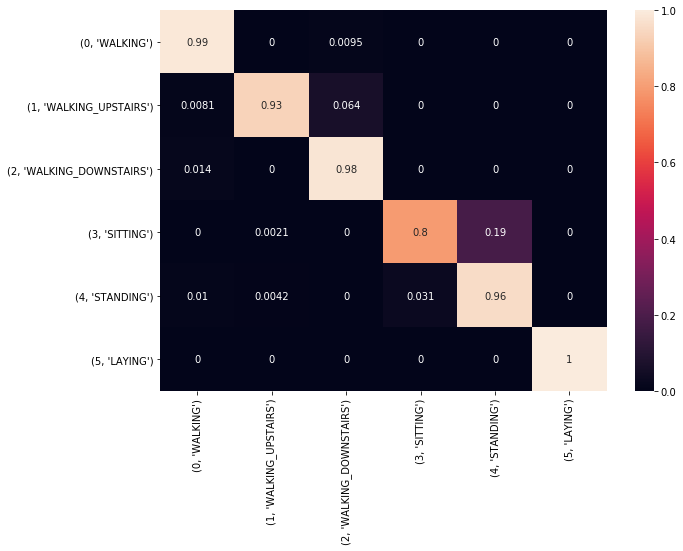

In [31]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

array = sklearn.metrics.confusion_matrix(y_true,y_pred)
array = array / array.astype(np.float).sum(axis=1)

df_cm = pd.DataFrame(array, index = [i for i in ACTIVITIES.items()],
                  columns = [i for i in ACTIVITIES.items()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()